В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------



0. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-2). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

1. Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

In [1126]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
import joblib

In [1128]:
df = pd.read_csv('bank-customer-churn-prediction-dlu-course-c-2/train.csv')

In [1130]:
df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,3,15645794.0,Macleod,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,4,15633840.0,Hsia,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0


In [1132]:
df.shape

(15000, 14)

In [1134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15000 non-null  int64  
 1   CustomerId       15000 non-null  float64
 2   Surname          15000 non-null  object 
 3   CreditScore      15000 non-null  float64
 4   Geography        15000 non-null  object 
 5   Gender           15000 non-null  object 
 6   Age              15000 non-null  float64
 7   Tenure           15000 non-null  float64
 8   Balance          15000 non-null  float64
 9   NumOfProducts    15000 non-null  float64
 10  HasCrCard        15000 non-null  float64
 11  IsActiveMember   15000 non-null  float64
 12  EstimatedSalary  15000 non-null  float64
 13  Exited           15000 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.6+ MB


Датасет не мiстить пропущених значень. 
Містить категоріальні та числові колонки.

In [1137]:
# видаляю стовпцi id та customerID
df.drop(columns=['id', 'CustomerId'], inplace = True)

<Axes: title={'center': 'No. of Exited'}, xlabel='Exited', ylabel='count'>

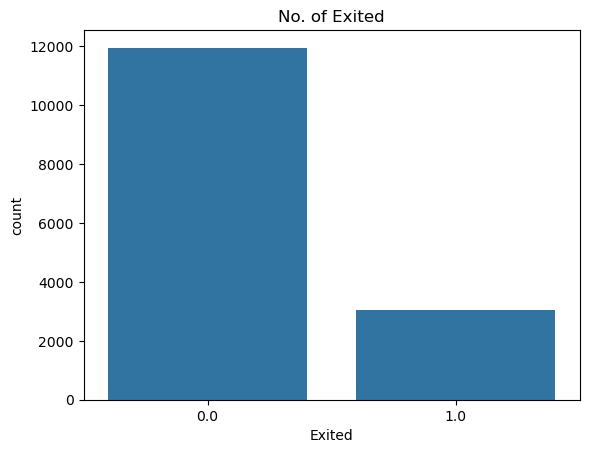

In [1139]:
plt.title('No. of Exited')
sns.countplot(x = df.Exited)

Таргет розподілений не рівномірно тому використовую параметр stratified, щоб в train та val таргет розподiлився пропорцiйно.

In [1142]:
# розбиваю на train та val
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42,  stratify = df.Exited)

In [1144]:
print('train_df.shape :', train_df.shape)
print('val_df.shape :', val_df.shape)

train_df.shape : (12000, 12)
val_df.shape : (3000, 12)


2. Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.

In [1147]:
input_cols = list(df.columns)[:-1]
target_col = 'Exited'

In [1149]:
print(input_cols)

['Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']


In [1151]:
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

3. Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно.

In [1154]:
numeric_cols = train_inputs.select_dtypes(include = np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

In [1156]:
numeric_cols

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary']

In [1158]:
categorical_cols

['Surname', 'Geography', 'Gender']

In [1160]:
train_inputs[numeric_cols].describe().round(2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00
mean,658.84,37.69,5.03,43008.17,1.59,0.79,0.49,117992.40
std,72.33,8.14,2.78,59906.63,0.53,0.41,0.50,45589.48
min,431.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58
25%,603.00,32.00,3.00,0.00,1.00,1.00,0.00,83343.73
50%,661.00,37.00,5.00,0.00,2.00,1.00,0.00,123613.91
75%,708.00,42.00,7.00,109949.05,2.00,1.00,1.00,156912.81
max,850.00,74.00,10.00,209767.31,4.00,1.00,1.00,199992.48


4. Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти пеердобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка маэ бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значен з `train_inputs`, `val_inputs` використовуючи `display()`.

#### 1. Масштабування числових ознак

Масштабую числовi ознаки, щоб значення були від 0 до 1, для того щоб ознаки не мали непропорційного впливу на функцію втрат.
Навчаю scaler на тренувальних даних та трансформую тренувальні та валідаційні.

In [1164]:
scaler = MinMaxScaler()

In [1166]:
scaler.fit(train_inputs[numeric_cols])

MinMaxScaler()

In [1168]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])

#### 2. Видалення колонки Surname

Оскільки ознака містить дуже багато унікальних значень, не застосовую OHE.

In [1171]:
train_inputs.drop(columns='Surname', inplace = True)
val_inputs.drop(columns='Surname', inplace = True)

In [1173]:
categorical_cols.remove('Surname')

#### 3. Кодування Geography та Gender

Застосую OneHotEncoder для категоріальних колонок щоб подати у модель числовi данi. 1 у випадку належностi до визначеної країни/статі, 0 - при належності до іншої.

In [1176]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

In [1178]:
encoder.fit(train_inputs[categorical_cols])

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [1180]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
print(encoded_cols)

['Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male']


In [1182]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])

In [1184]:
pd.set_option('display.max_columns', None)

In [1186]:
display(train_inputs.head())

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
7180,0.599045,France,Male,0.214286,0.1,0.626382,0.000000,1.0,1.0,0.719772,1.0,0.0,0.0,0.0,1.0
10393,0.603819,France,Female,0.375000,0.2,0.848836,0.000000,1.0,0.0,0.727603,1.0,0.0,0.0,1.0,0.0
80,0.653938,Germany,Male,0.303571,0.6,0.554522,0.333333,1.0,0.0,0.872180,0.0,1.0,0.0,0.0,1.0
3365,0.568019,Spain,Male,0.714286,0.0,0.000000,0.333333,0.0,1.0,0.257797,0.0,0.0,1.0,0.0,1.0
12236,0.658711,France,Male,0.053571,0.3,0.000000,0.333333,1.0,1.0,0.742837,1.0,0.0,0.0,0.0,1.0


In [1188]:
display(val_inputs.head())

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
6490,0.675418,Germany,Male,0.500000,0.1,0.551870,1.000000,1.0,1.0,0.364704,0.0,1.0,0.0,0.0,1.0
3646,0.386635,France,Male,0.410714,0.5,0.000000,0.333333,1.0,1.0,0.190942,1.0,0.0,0.0,0.0,1.0
5306,0.715990,France,Female,0.357143,0.2,0.000000,0.333333,0.0,1.0,0.584853,1.0,0.0,0.0,1.0,0.0
652,0.577566,France,Female,0.446429,0.4,0.742441,0.000000,0.0,1.0,0.558109,1.0,0.0,0.0,1.0,0.0
2627,0.589499,Spain,Female,0.214286,0.4,0.000000,0.333333,1.0,0.0,0.718420,0.0,0.0,1.0,1.0,0.0


5. Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

In [1191]:
!pip install pyarrow --quiet

In [1192]:
train_inputs.to_parquet('preprocess_data/train_inputs.parquet')
val_inputs.to_parquet('preprocess_data/val_inputs.parquet')

In [1193]:
pd.DataFrame(train_targets).to_parquet('preprocess_data/train_targets.parquet')
pd.DataFrame(val_targets).to_parquet('preprocess_data/val_targets.parquet')

In [1194]:
!ls preprocess_data

train_inputs.parquet  val_inputs.parquet
train_targets.parquet val_targets.parquet


6. З підготовлених вхіжних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

In [1196]:
train_inputs = pd.read_parquet('preprocess_data/train_inputs.parquet')
val_inputs = pd.read_parquet('preprocess_data/val_inputs.parquet')

In [1200]:
train_targets = pd.read_parquet('preprocess_data/train_targets.parquet')[target_col]
val_targets = pd.read_parquet('preprocess_data/val_targets.parquet')[target_col]

In [1204]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]

In [1206]:
model = LogisticRegression(solver='liblinear')

In [1208]:
model.fit(X_train, train_targets)

LogisticRegression(solver='liblinear')

7. Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якіст моделі? Вона хороша, погана, задовільна?

In [1211]:
train_preds = model.predict(X_train)
val_preds = model.predict(X_val)

In [1213]:
confusion_matrix(train_targets, train_preds)

array([[9177,  381],
       [1128, 1314]])

In [1215]:
def predict_and_plot(inputs, targets, name=''):
    preds = model.predict(inputs)

    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    
    cf = confusion_matrix(targets, preds, normalize = 'true')
    plt.figure()
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));

    return preds

Accuracy: 87.42%


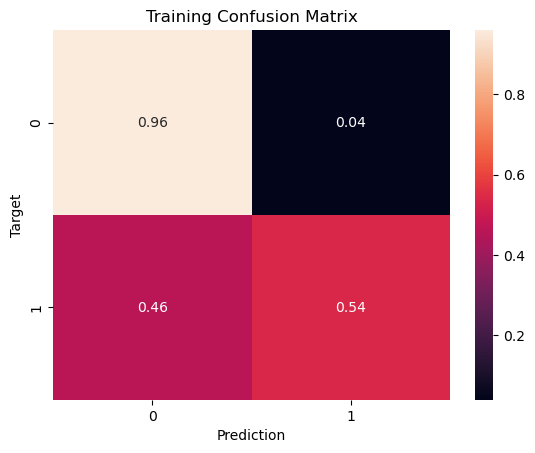

In [1217]:
train_preds = predict_and_plot(X_train, train_targets, 'Training')

Accuracy: 87.17%


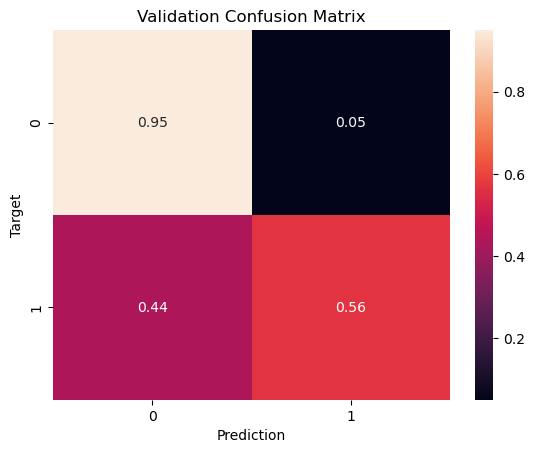

In [1219]:
val_preds = predict_and_plot(X_val, val_targets, 'Validation')

In [1220]:
def get_f1_score(inputs, targets, name=''):
  preds = model.predict(inputs)

  f1_score_ = f1_score(targets, preds)
  print(f"F1 score {name}: {f1_score_:.2f}%")

get_f1_score(X_train, train_targets, 'Training')
get_f1_score(X_val, val_targets, 'Validation')

F1 score Training: 0.64%
F1 score Validation: 0.64%


In [1223]:
def compute_auroc_and_build_roc(inputs, targets, name=''):
  # Predict probabilities
  y_pred_proba = model.predict_proba(inputs)[:, 1]

  # Compute ROC curve
  fpr, tpr, thresholds = roc_curve(targets, y_pred_proba)

    # Compute AUCROC
  roc_auc = auc(fpr, tpr)
  print(f'AUCROC for {name}: {roc_auc:.2f}')

  # Plot the ROC curve
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name}')
  plt.legend(loc="lower right")
  plt.show()

AUCROC for Training: 0.88


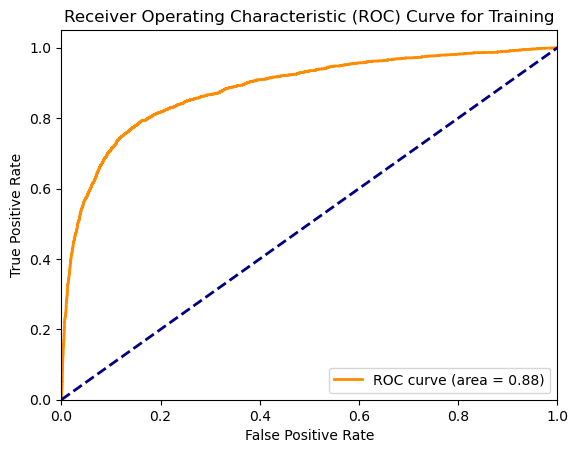

AUCROC for Validation: 0.88


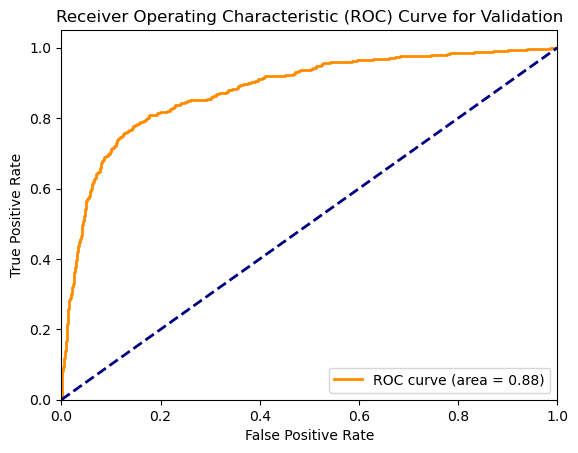

In [1225]:
compute_auroc_and_build_roc(X_train, train_targets, 'Training')
compute_auroc_and_build_roc(X_val, val_targets, 'Validation')

Модель задовiльна auc = 0.88 означає що модель добре розділяє класи, але дивлячись на confusion matrix бачимо що модель дуже добре знаходить target = 0, але цiльових target = 1 знайшла лише 54%.

8. Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

In [1229]:
def all_no(inputs):
    return np.full(len(inputs), 0)

In [1231]:
print("Accuracy all_no train: ", accuracy_score(train_targets, all_no(X_train)))
print("Accuracy model train: ", accuracy_score(train_targets, model.predict(X_train)))
print()
print("Accuracy all_no validation: ", accuracy_score(val_targets, all_no(X_val)))
print("Accuracy model validation: ", accuracy_score(val_targets, model.predict(X_val)))

Accuracy all_no train:  0.7965
Accuracy model train:  0.87425

Accuracy all_no validation:  0.7966666666666666
Accuracy model validation:  0.8716666666666667


Для обох вибiрок побудована модель краща за модель "завжди нi". Якiсть задовiльна, як для базової моделi.

9. Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

In [1235]:
exited = {
    'model': model,
    'scaler': scaler,
    'encoder': encoder,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols
}

In [1237]:
joblib.dump(exited, 'exited.joblib')

['exited.joblib']

In [1239]:
exited_2 = joblib.load('exited.joblib')

In [1241]:
model_2 = exited_2['model']

In [1243]:
model_2

LogisticRegression(solver='liblinear')

10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

In [1246]:
import warnings
warnings.filterwarnings("ignore")

def predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, input_df: pd.DataFrame):
    #input_df.drop(columns=['Surname','id', 'CustomerId'], inplace = True)
    categorical_cols.remove('Surname')
    numeric_cols.remove('id')
    numeric_cols.remove('CustomerId')
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
    X_input = input_df[numeric_cols + encoded_cols]
    prob = model.predict_proba(X_input)[:,1]
    return prob

11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

In [1249]:
test_raw_df = pd.read_csv('bank-customer-churn-prediction-dlu-course-c-2/test.csv')

In [1251]:
numeric_cols_test = test_raw_df.select_dtypes(include = np.number).columns.tolist()
categorical_cols_test = test_raw_df.select_dtypes('object').columns.tolist()

In [1253]:
test_raw_df['Exited'] = predict_raw_df(scaler, encoder, numeric_cols_test, categorical_cols_test, test_raw_df)

In [1255]:
test_raw_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Exited
0,15000,15594796.0,Chu,0.365155,Germany,Male,0.214286,0.2,0.696265,0.000000,1.0,1.0,0.789477,0.0,1.0,0.0,0.0,1.0,0.075316
1,15001,15642821.0,Mazzi,0.286396,France,Male,0.375000,0.5,0.000000,0.333333,1.0,1.0,0.337131,1.0,0.0,0.0,0.0,1.0,0.035366
2,15002,15716284.0,Onyekachi,0.656325,France,Male,0.446429,0.8,0.000000,0.333333,1.0,0.0,0.783859,1.0,0.0,0.0,0.0,1.0,0.153210
3,15003,15785078.0,Martin,0.682578,Spain,Male,0.482143,0.3,0.000000,0.000000,1.0,1.0,0.834571,0.0,0.0,1.0,0.0,1.0,0.194872
4,15004,15662955.0,Kenechukwu,0.384248,Spain,Male,0.446429,0.8,0.000000,0.333333,1.0,1.0,0.718421,0.0,0.0,1.0,0.0,1.0,0.055660


12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

In [1258]:
sample_submission = pd.read_csv('bank-customer-churn-prediction-dlu-course-c-2/sample_submission.csv')

In [1260]:
sample_submission['Exited'] = test_raw_df['Exited']

In [1262]:
sample_submission.head()

,id,Exited
0,15000,0.075316
1,15001,0.035366
2,15002,0.153210
3,15003,0.194872
4,15004,0.055660


In [1264]:
sample_submission.to_csv('submission_log_reg.csv', index=False)